# Solar radiation prediction
This notebook presents data analysis on a four-month dataset collected at the HI-SEAS weather station (Hawaii). The sampling rate is around 5 minutes. The objective is to derive a machine learning (ML) model to forecast solar radiation as a function of the available features.
## Dataset
The dataset consists of 
* Solar radiation [W/m^2]
* Temperature [F]
* Atmospheric pressure [Hg]
* Humidity [%]
* Wind speed [miles/h]
* Wind direction [degrees]



In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns
import plotly.express as px 
sns.set_style('darkgrid')


In [25]:
dataset=pd.read_csv("solar_radiation_dataset.csv")
dataset.head()
# print(dataset.iloc[0])
# for train_index, test_index in tscv.split(dataset):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = dataset[train_index], dataset[test_index]

UNIXTime                   Data      Time  Radiation  Temperature  \
0  1475229326  9/29/2016 12:00:00 AM  23:55:26       1.21           48   
1  1475229023  9/29/2016 12:00:00 AM  23:50:23       1.21           48   
2  1475228726  9/29/2016 12:00:00 AM  23:45:26       1.23           48   
3  1475228421  9/29/2016 12:00:00 AM  23:40:21       1.21           48   
4  1475228124  9/29/2016 12:00:00 AM  23:35:24       1.17           48   

   Pressure  Humidity  WindDirection(Degrees)  Speed TimeSunRise TimeSunSet  
0     30.46        59                  177.39   5.62    06:13:00   18:13:00  
1     30.46        58                  176.78   3.37    06:13:00   18:13:00  
2     30.46        57                  158.75   3.37    06:13:00   18:13:00  
3     30.46        60                  137.71   3.37    06:13:00   18:13:00  
4     30.46        62                  104.95   5.62    06:13:00   18:13:00

# Time Feature Engineering

In [26]:
Wind_Direction = dataset["WindDirection(Degrees)"]
dataset = dataset.drop(["UNIXTime", "WindDirection(Degrees)"], axis = 1)
dataset["Wind_Direction"] = Wind_Direction
dataset.head()

Data      Time  Radiation  Temperature  Pressure  \
0  9/29/2016 12:00:00 AM  23:55:26       1.21           48     30.46   
1  9/29/2016 12:00:00 AM  23:50:23       1.21           48     30.46   
2  9/29/2016 12:00:00 AM  23:45:26       1.23           48     30.46   
3  9/29/2016 12:00:00 AM  23:40:21       1.21           48     30.46   
4  9/29/2016 12:00:00 AM  23:35:24       1.17           48     30.46   

   Humidity  Speed TimeSunRise TimeSunSet  Wind_Direction  
0        59   5.62    06:13:00   18:13:00          177.39  
1        58   3.37    06:13:00   18:13:00          176.78  
2        57   3.37    06:13:00   18:13:00          158.75  
3        60   3.37    06:13:00   18:13:00          137.71  
4        62   5.62    06:13:00   18:13:00          104.95

In [27]:
import re
import datetime
from datetime import date

day = [] ; month = [] ; year = []
for string in dataset["Data"]:
    match = re.search(r'\d+/\d+/\d+', string)
    date = datetime.datetime.strptime(match.group(), '%m/%d/%Y').date()
    day.append(date.day)
    month.append(date.month)
    year.append(date.year)

dataset["Day"] = day ; dataset["Month"] = month ; dataset["Year"] = year
dataset = dataset.drop("Data", axis = 1)
dataset.head()

Time  Radiation  Temperature  Pressure  Humidity  Speed TimeSunRise  \
0  23:55:26       1.21           48     30.46        59   5.62    06:13:00   
1  23:50:23       1.21           48     30.46        58   3.37    06:13:00   
2  23:45:26       1.23           48     30.46        57   3.37    06:13:00   
3  23:40:21       1.21           48     30.46        60   3.37    06:13:00   
4  23:35:24       1.17           48     30.46        62   5.62    06:13:00   

  TimeSunSet  Wind_Direction  Day  Month  Year  
0   18:13:00          177.39   29      9  2016  
1   18:13:00          176.78   29      9  2016  
2   18:13:00          158.75   29      9  2016  
3   18:13:00          137.71   29      9  2016  
4   18:13:00          104.95   29      9  2016

<AxesSubplot:>

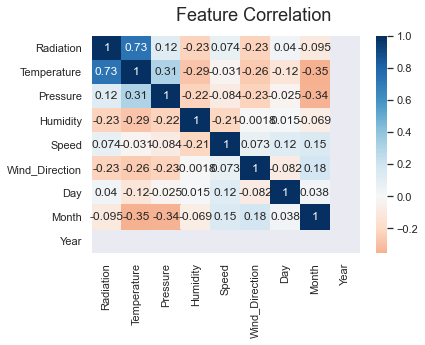

In [28]:
fig = plt.figure()
fig.suptitle('Feature Correlation', fontsize=18)
sns.heatmap(dataset.corr(), annot=True, cmap='RdBu', center=0)

## Feature creation from Time

In [29]:
from datetime import time

def time_conversion_to_second(time_to_convert):
    time_converted = datetime.datetime.strptime(time_to_convert, '%H:%M:%S').time()
    time_in_second = time_converted.hour * 3600 + time_converted.minute * 60 + time_converted.second
    return time_in_second
    
def sun_is_up(current_time, rising_time, set_time):
    current_time_second = time_conversion_to_second(current_time)
    rising_time_second = time_conversion_to_second(rising_time)
    set_time_second = time_conversion_to_second(set_time)
    
    return (rising_time_second < current_time_second) and (current_time_second < set_time_second)

Sun_is_up = [sun_is_up(dataset["Time"][index], dataset["TimeSunRise"][index], dataset["TimeSunSet"][index]) for index in range(dataset.shape[0])]
Sun_is_up = np.array(Sun_is_up, dtype = int)

dataset["Sun_is_up"] = Sun_is_up

proportion = round(sum(dataset["Sun_is_up"]/dataset.shape[0]*100), 2)
print("Proportion of record with the sun up : {0}%".format(proportion))

Proportion of record with the sun up : 47.75%


In [30]:
def soustract_time(time1, time2):
    hour = time1.hour - time2.hour
    if time1.minute > time2.minute:
        minute = (time1.minute - time2.minute) / 60
    else:
        hour -= 1
        minute = (time1.minute + 60 - time2.minute) / 60
    return hour + minute
    

def sun_time_count(current_time, rising_time):
    current_time_converted = datetime.datetime.strptime(current_time, '%H:%M:%S').time()
    rising_time_converted = datetime.datetime.strptime(rising_time, '%H:%M:%S').time()
    
    return soustract_time(current_time_converted, rising_time_converted)

Sun_hour_count = [dataset["Sun_is_up"][index] * sun_time_count(dataset["Time"][index], dataset["TimeSunRise"][index]) for index in range(dataset.shape[0])]
dataset["Sun_hour_count"] = Sun_hour_count

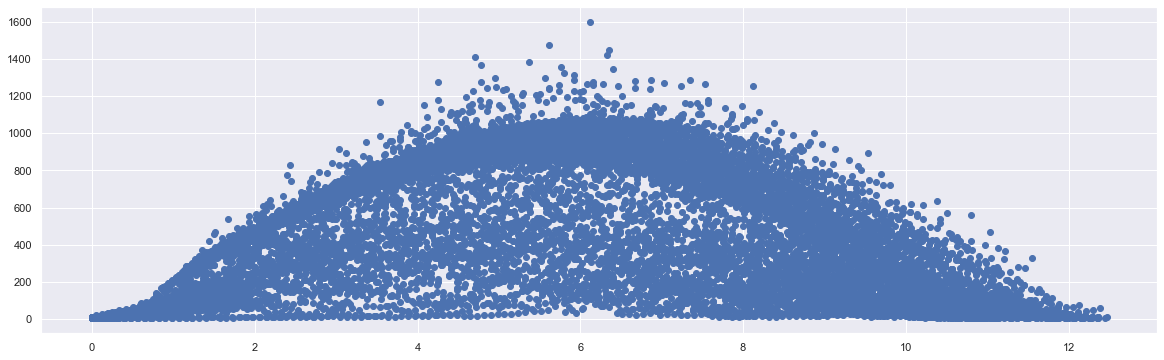

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

data = dataset[dataset["Sun_is_up"] == 1]

fig = plt.figure(figsize=(20, 6))

plt.scatter(data["Sun_hour_count"], data["Radiation"])
plt.show()

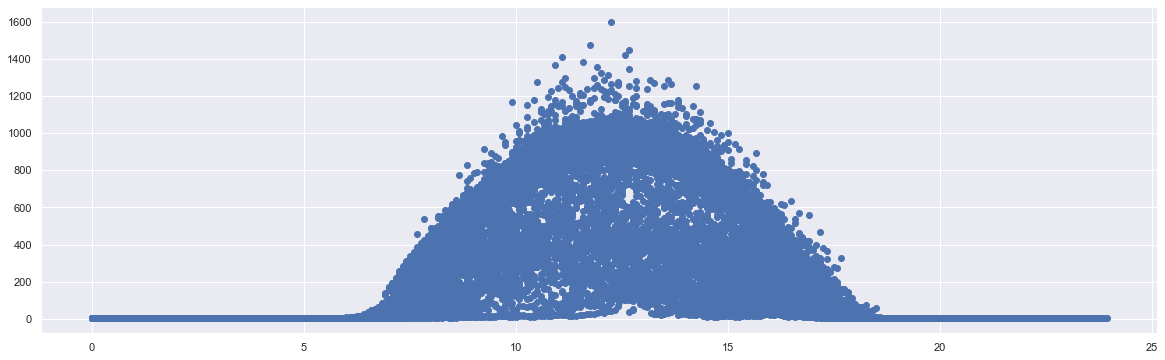

In [32]:
def extract_time(current_time):
    current_time_converted = datetime.datetime.strptime(current_time, '%H:%M:%S').time()
    return current_time_converted.hour + current_time_converted.minute / 60

Hour = [extract_time(dataset["Time"][index]) for index in range(dataset.shape[0])]

dataset["Hour"] = Hour
fig = plt.figure(figsize=(20, 6))
plt.scatter(Hour, dataset["Radiation"])
plt.show()

In [33]:
def plot_radiation_profil(day, month):
    df_day = dataset[(dataset["Day"] == day) & (dataset["Month"] == month)]
    label = "{0}/{1}/2016".format(day, month)
    plt.plot(df_day["Hour"],df_day["Radiation"], label = label)

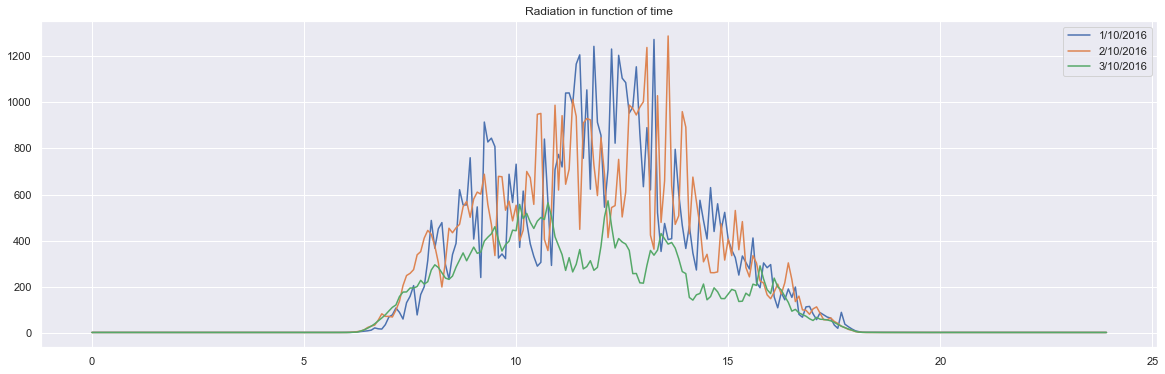

In [34]:
fig = plt.figure(figsize=(20, 6))
plot_radiation_profil(1, 10)
plot_radiation_profil(2, 10)
plot_radiation_profil(3, 10)

plt.title("Radiation in function of time")
plt.legend()
plt.show()

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
def evaluate_model(model, X_train, y_train, X_test, y_test):
    print("Evaluating model: ", type(model).__name__)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_true = y_test, y_pred = y_pred)
    R2 = r2_score(y_true = y_test, y_pred = y_pred)
    print("\tMSE : {0} and R2 : {1}".format(MSE, R2))
    

## Naive Model

In [36]:
data = dataset

Rise_Hour = [extract_time(data["TimeSunRise"][index]) for index in range(data.shape[0])]
Set_Hour = [extract_time(data["TimeSunSet"][index]) for index in range(data.shape[0])]

data["Rise_Hour"] = Rise_Hour
data["Set_Hour"] = Set_Hour
data = data.drop(["Time", "TimeSunRise", "TimeSunSet"], axis = 1)
data.head()

Radiation  Temperature  Pressure  Humidity  Speed  Wind_Direction  Day  \
0       1.21           48     30.46        59   5.62          177.39   29   
1       1.21           48     30.46        58   3.37          176.78   29   
2       1.23           48     30.46        57   3.37          158.75   29   
3       1.21           48     30.46        60   3.37          137.71   29   
4       1.17           48     30.46        62   5.62          104.95   29   

   Month  Year  Sun_is_up  Sun_hour_count       Hour  Rise_Hour   Set_Hour  
0      9  2016          0             0.0  23.916667   6.216667  18.216667  
1      9  2016          0             0.0  23.833333   6.216667  18.216667  
2      9  2016          0             0.0  23.750000   6.216667  18.216667  
3      9  2016          0             0.0  23.666667   6.216667  18.216667  
4      9  2016          0             0.0  23.583333   6.216667  18.216667

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = data.drop(["Radiation","Month","Day"], axis = 1)
y = data["Radiation"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

evaluate_model(LinearRegression(), X_train, y_train, X_test, y_test)
evaluate_model(RandomForestRegressor(max_depth=5, random_state=0), X_train, y_train, X_test, y_test)
evaluate_model(svm.SVR(kernel='rbf'), X_train, y_train, X_test, y_test)




Evaluating model:  LinearRegression
	MSE : 32586.256915395534 and R2 : 0.6790467001017952
Evaluating model:  RandomForestRegressor
	MSE : 15126.523306928397 and R2 : 0.8510136471350274
Evaluating model:  SVR
	MSE : 28524.404509490752 and R2 : 0.7190532874419533


In [38]:
# def see_prediction_error(number_to_see):
#     Y = y_test.iloc[:number_to_see]
#     X = [i for i in range(len(Y))]

#     fig = plt.figure(figsize=(20, 10))

#     for index in range(len(X)):
#         plt.plot([X[index], X[index]], [Y.iloc[index], y_pred[index]], c="black")
#     plt.plot(X, Y, 'o', label='True')
#     plt.plot(X, y_pred[:number_to_see], 'o', label='Predicted')

#     plt.title("Prediction vs real radiation values")
#     plt.legend()
#     plt.show()
    
# number_to_see = 100
# see_prediction_error(number_to_see)

## cosinus and sinus time

In [39]:
# dataset.head()
from datetime import time
from math import cos, sin, pi

def extract_and_convert_time_to_trigonometric(List):
    cos_time = [] ; sin_time = []
    period = 2 * pi / (3600 * 24)
    for time in List:
        converted_time = datetime.datetime.strptime(time, '%H:%M:%S').time()
        time_in_second = 3600 * converted_time.hour + 60 * converted_time.minute + converted_time.second
        cos_time.append(cos(time_in_second * period)) ; sin_time.append(sin(time_in_second * period))
    return cos_time, sin_time

def extract_and_replace(column_name, data, name_cos, name_sin):
    cos_time, sin_time = extract_and_convert_time_to_trigonometric(data[column_name])
    data[name_cos] = cos_time ; data[name_sin] = sin_time
    data = data.drop(column_name, axis = 1)
    return data

dataset = extract_and_replace(column_name = "Time", data = dataset, name_cos = "Cos_time", name_sin = "Sin_time")
dataset = extract_and_replace(column_name = "TimeSunRise", data = dataset, name_cos = "Cos_rise_time", name_sin = "Sin_rise_time")
dataset = extract_and_replace(column_name = "TimeSunSet", data = dataset, name_cos = "Cos_set_time", name_sin = "Sin_set_time")
dataset.head()

Radiation  Temperature  Pressure  Humidity  Speed  Wind_Direction  Day  \
0       1.21           48     30.46        59   5.62          177.39   29   
1       1.21           48     30.46        58   3.37          176.78   29   
2       1.23           48     30.46        57   3.37          158.75   29   
3       1.21           48     30.46        60   3.37          137.71   29   
4       1.17           48     30.46        62   5.62          104.95   29   

   Month  Year  Sun_is_up  Sun_hour_count       Hour  Rise_Hour   Set_Hour  \
0      9  2016          0             0.0  23.916667   6.216667  18.216667   
1      9  2016          0             0.0  23.833333   6.216667  18.216667   
2      9  2016          0             0.0  23.750000   6.216667  18.216667   
3      9  2016          0             0.0  23.666667   6.216667  18.216667   
4      9  2016          0             0.0  23.583333   6.216667  18.216667   

   Cos_time  Sin_time  Cos_rise_time  Sin_rise_time  Cos_set_time  \
0  0.999801 -0.019925      -0.056693       0.998392      0.056693   
1  0.999120 -0.041948      -0.056693       0.998392      0.056693   
2  0.997981 -0.063516      -0.056693       0.998392      0.056693   
3  0.996327 -0.085634      -0.056693       0.998392      0.056693   
4  0.994245 -0.107132      -0.056693       0.998392      0.056693   

   Sin_set_time  
0     -0.998392  
1     -0.998392  
2     -0.998392  
3     -0.998392  
4     -0.998392

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = dataset.drop(["Radiation","Month","Day"], axis = 1)
y = dataset["Radiation"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

evaluate_model(Lasso(), X_train, y_train, X_test, y_test)
evaluate_model(LinearRegression(), X_train, y_train, X_test, y_test)
evaluate_model(RandomForestRegressor(max_depth=5, random_state=0), X_train, y_train, X_test, y_test)
evaluate_model(svm.SVR(kernel='rbf'), X_train, y_train, X_test, y_test)
# print("Liner Regression")
# regression_model = LinearRegression()
# regression_model.fit(X_train, y_train)
# y_pred = regression_model.predict(X_test)
# MSE = mean_squared_error(y_true = y_test, y_pred = y_pred)
# R2 = r2_score(y_true = y_test, y_pred = y_pred)
# print("MSE : {0} and R2 : {1}".format(MSE, R2))

# print("Random Forest")
# random_forest = RandomForestRegressor(max_depth=5, random_state=0)
# random_forest.fit(X_train, y_train)
# y_pred = random_forest.predict(X_test)
# MSE = mean_squared_error(y_true = y_test, y_pred = y_pred)
# R2 = r2_score(y_true = y_test, y_pred = y_pred)
# print("MSE : {0} and R2 : {1}".format(MSE, R2))

# print("SVM")
# svr = svm.SVR(kernel='rbf')
# svr.fit(X_train, y_train)
# y_pred = svr.predict(X_test)
# MSE = mean_squared_error(y_true = y_test, y_pred = y_pred)
# R2 = r2_score(y_true = y_test, y_pred = y_pred)
# print("MSE : {0} and R2 : {1}".format(MSE, R2))



NameError: name 'linear_model' is not defined